In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from PyNEC import *
from antenna_util import *
from context_clean import *
import math

In [6]:
brass_conductivity = 15600000 # mhos
tl_impedance = 75.0
frequency_ranges = ((2350, 2550), (4950, 5050))
system_impedance = 50
design_freq_mhz = 2450
wavelength = 299792e3 / (design_freq_mhz * 1e6)

In [7]:
def geometry_logperiodic(l_1, x_1, tau):
    wire_radius = 0.00025 # 0.25 mm
    nec = context_clean(nec_context())
    nec.set_extended_thin_wire_kernel(True)
    geo = geometry_clean(nec.get_geometry())

    x_i = x_1
    l_i = l_1
    
    dipole_center_segs = {}
    dipoles_count = 6

    for dipole_tag in range(1, dipoles_count + 1):
        nr_segments = int(math.ceil(50*l_i/wavelength))
        dipole_center_segs[dipole_tag] = nr_segments // 2 + 1
        center = np.array([x_i, 0, 0])
        half_height = np.array([0, 0, l_i/2.0])
        top = center + half_height
        bottom = center - half_height
        geo.wire(tag_id=dipole_tag, nr_segments=nr_segments, src=bottom, dst=top, radius=wire_radius)
        x_i = tau * x_i
        l_i = tau * l_i

    nec.set_wire_conductivity(brass_conductivity)
    nec.geometry_complete(ground_plane=False)

    for dipole in range(0, dipoles_count - 1):
        src_tag = int(1 + dipole)
        src_seg = dipole_center_segs[src_tag]
        dst_tag = src_tag + 1
        dst_seg = dipole_center_segs[dst_tag]
        nec.transmission_line((src_tag, src_seg), (dst_tag, dst_seg), tl_impedance, crossed_line=True)

    smallest_dipole_tag = dipoles_count
    nec.voltage_excitation(wire_tag=smallest_dipole_tag, segment_nr=dipole_center_segs[smallest_dipole_tag], voltage=1.0)

    return nec


In [8]:
def get_gain_swr_range(l_1, x_1, tau, start=2300, stop=5900, step=10):
    gains_db = []
    frequencies = []
    vswrs = []
    for freq in range(start, stop + 1, step):
        nec = geometry_logperiodic(l_1, x_1, tau)
        nec.set_frequency(freq)
        nec.radiation_pattern(thetas=Range(90, 90, count=1), phis=Range(180, 180, count=1))
        rp = nec.context.get_radiation_pattern(0)
        ipt = nec.get_input_parameters(0)
        z = ipt.get_impedance()
        gains_db.append(rp.get_gain()[0])
        vswrs.append(vswr(z, system_impedance))
        frequencies.append(ipt.get_frequency())

    return frequencies, gains_db, vswrs

In [9]:
# Função para calcular ganho e VSWR
def get_gain_swr_range(l_1, x_1, tau, start=2300, stop=5900, step=10):
    gains_db = []
    frequencies = []
    vswrs = []
    for freq in range(start, stop + 1, step):
        nec = geometry_logperiodic(l_1, x_1, tau)
        nec.set_frequency(freq)
        nec.radiation_pattern(thetas=Range(90, 90, count=1), phis=Range(180, 180, count=1))
        rp = nec.context.get_radiation_pattern(0)
        ipt = nec.get_input_parameters(0)
        z = ipt.get_impedance()
        gains_db.append(rp.get_gain()[0])
        vswrs.append(vswr(z, system_impedance))
        frequencies.append(ipt.get_frequency())
    return frequencies, gains_db, vswrs


In [10]:
def optimization_targets(args):
    l_1, x_1, tau = args
    if l_1 <= 0 or x_1 <= 0 or tau <= 0:
        return float('inf'), float('inf')

    try:
        vswr_score = 0
        gains_score = 0

        for range_low, range_high in frequency_ranges:
            freqs, gains, vswrs = get_gain_swr_range(l_1, x_1, tau, start=range_low, stop=range_high)
            gains_score += sum(gains)
            for vswr in vswrs:
                if vswr >= 1.8:
                    vswr = min(np.exp(vswr), 1e6)  # Evitar overflow
                vswr_score += vswr
                
        result1 = - gains_score[0]
        result2 = vswr_score

    except Exception as e:
        print(f"Caught exception: {e}")
        return float('inf'), float('inf')

    # Debugging output
    if not np.isscalar(result1) or not np.isscalar(result2):
        print(f"Non-scalar fitness values detected: result1={result1}, result2={result2}")

    # check if is complex
    if np.iscomplex(result1) or np.iscomplex(result2):
        # return module of complex number
        return np.abs(result1), np.abs(result2)

    return result1, result2

In [11]:
def real_values(args):
    l_1, x_1, tau = args
    if l_1 <= 0 or x_1 <= 0 or tau <= 0:
        return float('inf'), float('inf')

    try:
        vswr_score = 0
        gains_score = 0
        iter = 0

        for range_low, range_high in frequency_ranges:
            freqs, gains, vswrs = get_gain_swr_range(l_1, x_1, tau, start=range_low, stop=range_high)
            gains_score += sum(gains)
            for vswr in vswrs:
                vswr_score += vswr
            
            iter += 1
                
        result1 = - gains_score[0]
        result2 = vswr_score

    except Exception as e:
        print(f"Caught exception: {e}")
        return float('inf'), float('inf')

    # Debugging output
    if not np.isscalar(result1) or not np.isscalar(result2):
        print(f"Non-scalar fitness values detected: result1={result1}, result2={result2}")

    return result1/iter, result2/iter

In [12]:
def simulate_and_get_impedance(nec):
    nec.set_frequency(design_freq_mhz)
    nec.xq_card(0)
    index = 0
    impedance = nec.get_input_parameters(index).get_impedance()
    if isinstance(impedance, np.ndarray):
        impedance = impedance[0]
    return impedance

system_impedance = 50
design_freq_mhz = 2450
wavelength = 299792e3 / (design_freq_mhz * 1e6)

In [13]:
def draw_frequencie_ranges(ax):
    ax.axvline(x=frequency_ranges[0][0], color='red', linewidth=1)
    ax.axvline(x=frequency_ranges[0][1], color='red', linewidth=1)
    ax.axvline(x=frequency_ranges[1][0], color='red', linewidth=1)
    ax.axvline(x=frequency_ranges[1][1], color='red', linewidth=1)

In [14]:
def show_report(l1, x1, tau):
    nec = geometry_logperiodic(l1, x1, tau)
    z = simulate_and_get_impedance(nec)
    print(f"Initial impedance: ({z.real:.1f},{z.imag:+.1f}I) Ohms")
    print(f"VSWR @ 50 Ohm is {vswr(z, 50):.6f}")

    freqs, gains, vswrs = get_gain_swr_range(l1, x1, tau, step=5)
    freqs = np.array(freqs) / 1e6

    fig, ax1 = plt.subplots()
    ax1.plot(freqs, gains, 'b-')
    ax1.set_xlabel('Frequency (MHz)')
    ax1.set_ylabel('Gain (dB)', color='b')
    draw_frequencie_ranges(ax1)

    ax2 = ax1.twinx()
    ax2.plot(freqs, vswrs, 'r-')
    ax2.set_ylabel('VSWR', color='r')
    ax2.set_yscale('log')

    plt.title("Gain and VSWR of a 6-element log-periodic antenna")
    fig.tight_layout()
    plt.show()

In [15]:
def plot_pareto_front(pop):
    """ Plots the Pareto front given a population """
    # pareto_front = np.array([ind.fitness.values for ind in pop])

    # pareto front using real_values
    pareto_front = np.array([real_values(ind) for ind in pop])

    plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c='r', label='Pareto Front')
    plt.xlabel('VSWR Score - Gains Score')
    plt.ylabel('VSWR Score')
    plt.title('Pareto Front')
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -5.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float_l1", np.random.uniform, 0.01, 0.2)
toolbox.register("attr_float_x1", np.random.uniform, 0.01, 0.2)
toolbox.register("attr_float_tau", np.random.uniform, 0.7, 0.9)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_float_l1, toolbox.attr_float_x1, toolbox.attr_float_tau), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", optimization_targets)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=[0.01, 0.01, 0.7], up=[0.2, 0.2, 0.9], eta=0.1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

def main():
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    algorithms.eaMuPlusLambda(pop, toolbox, mu=50, lambda_=100, cxpb=0.7, mutpb=0.2, ngen=50, stats=stats, halloffame=hof, verbose=True)

    return pop, stats, hof

Wavelength is 0.1224m, initial length is 0.0612m
Unoptimized antenna...
Initial impedance: (84.7,+4.8I) Ohms
VSWR @ 50 Ohm is 1.702385


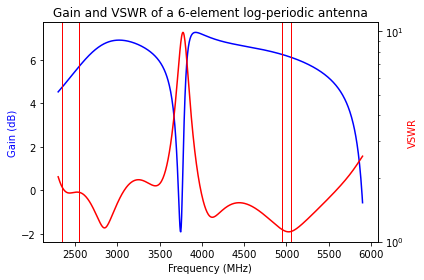

Optimizing antenna with NSGA-II...


/home/henrique/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


gen	nevals	avg                              	std                            	min                          	max                            
0  	50    	[-8.05038338e+01  6.96218886e+06]	[8.75217723e+01 9.07647954e+06]	[-221.70909578   43.1795506 ]	[1.66329226e+02 2.11376155e+07]
1  	90    	[-1.63922219e+02  1.32930288e+06]	[4.34848109e+01 4.27515198e+06]	[-236.17827064   40.41262302]	[-3.42294056e+01  2.10000829e+07]
2  	90    	[-183.14671122  861.79434266]    	[  41.57321045 3690.60369791]  	[-245.24779202   40.41262302]	[  -34.2294056 25458.2265817]    
3  	91    	[-193.04219253  186.56831871]    	[ 47.96187995 184.36464303]    	[-245.24779202   40.41262302]	[-31.95683997 852.59110197]      
4  	92    	[-192.03956301  123.7070932 ]    	[ 49.91782414 132.66508384]    	[-245.24779202   40.41262302]	[-34.2294056  506.82761162]      
5  	92    	[-200.17345149  132.33983701]    	[ 50.14354435 167.74053288]    	[-246.06149162   40.41262302]	[-34.2294056  506.82761162]      
6  	91    	[-215.

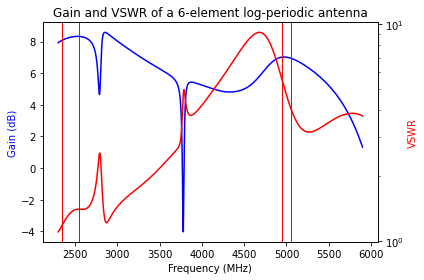

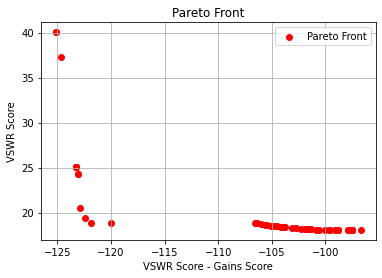

In [24]:
initial_l1 = wavelength / 2
initial_x1 = wavelength / 2
initial_tau = 0.8

print(f"Wavelength is {wavelength:.4f}m, initial length is {initial_l1:.4f}m")
print("Unoptimized antenna...")
show_report(initial_l1, initial_x1, initial_tau)

print("Optimizing antenna with NSGA-II...")
pop, stats, hof = main()

best_ind = hof[0]
optimized_l1, optimized_x1, optimized_tau = best_ind[0], best_ind[1], best_ind[2]

print("Optimized antenna...")
show_report(optimized_l1, optimized_x1, optimized_tau)

plot_pareto_front(pop)

# Algoritmo próprio

## Operador de cruzamento

In [ ]:
def crossover(parent1, parent2, alpha=0.5):
    child1 = alpha * np.array(parent1) + (1 - alpha) * np.array(parent2)
    child2 = alpha * np.array(parent2) + (1 - alpha) * np.array(parent1)
    return child1.tolist(), child2.tolist()

## Operador de mutação

In [ ]:
def mutate(individual, low=[0.01, 0.01, 0.7], up=[0.2, 0.2, 0.9], eta=0.1):
    for i in range(len(individual)):
        if np.random.rand() < 0.2:  # Taxa de mutação
            individual[i] += np.random.uniform(-eta, eta)
            individual[i] = max(min(individual[i], up[i]), low[i])
    return individual

## Ranking e Crowding Distance

In [ ]:
def fast_non_dominated_sort(values1, values2):
    S = [[] for _ in range(len(values1))]
    front = [[]]
    n = [0] * len(values1)
    rank = [0] * len(values1)

    for p in range(len(values1)):
        S[p] = []
        for q in range(len(values1)):
            if (values1[p] < values1[q] and values2[p] < values2[q]) or (values1[p] <= values1[q] and values2[p] < values2[q]) or (values1[p] < values1[q] and values2[p] <= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] < values1[p] and values2[q] < values2[p]) or (values1[q] <= values1[p] and values2[q] < values2[p]) or (values1[q] < values1[p] and values2[q] <= values2[p]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while front[i] != []:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    if q not in Q:
                        Q.append(q)
        i += 1
        front.append(Q)

    del front[len(front)-1]

    return front

def crowding_distance(values1, values2, front):
    distance = [0] * len(front)
    sorted1 = np.argsort([values1[i] for i in front])
    sorted2 = np.argsort([values2[i] for i in front])
    distance[sorted1[0]] = distance[sorted1[-1]] = float('inf')
    distance[sorted2[0]] = distance[sorted2[-1]] = float('inf')
    for k in range(1, len(front) - 1):
        distance[sorted1[k]] += (values1[sorted1[k+1]] - values1[sorted1[k-1]]) / (max(values1) - min(values1))
        distance[sorted2[k]] += (values2[sorted2[k+1]] - values2[sorted2[k-1]]) / (max(values2) - min(values2))
    return distance

# Função para plotar o gráfico
def get_pareto_front(population):
    values1 = []
    values2 = []
    for ind in population:
        f1, f2 = optimization_targets(ind)
        values1.append(f1)
        values2.append(f2)
    
    front = fast_non_dominated_sort(values1, values2)
    pareto_front = []
    for f in front[0]:
        pareto_front.append(population[f])
    return pareto_front

## Seleção

In [ ]:
def selection(pop, values1, values2):
    front = fast_non_dominated_sort(values1, values2)
    new_pop = []
    for f in front:
        if len(new_pop) + len(f) > len(pop):
            distance = crowding_distance(values1, values2, f)
            f = [x for _, x in sorted(zip(distance, f), reverse=True)]
            new_pop.extend(f[:len(pop) - len(new_pop)])
            break
        else:
            new_pop.extend(f)
    return [pop[i] for i in new_pop]

## Main

In [ ]:
def main():
    pop_size = 50
    generations = 10
    population = [[np.random.uniform(0.01, 0.2), np.random.uniform(0.01, 0.2), np.random.uniform(0.7, 0.9)] for _ in range(pop_size)]

    for gen in range(generations):
        values1 = []
        values2 = []
        for ind in population:
            f1, f2 = optimization_targets(ind)
            values1.append(f1)
            values2.append(f2)
        
        new_population = []
        while len(new_population) < pop_size:
            parent_indices = np.random.choice(range(len(population)), 2, replace=False)
            parent1 = population[parent_indices[0]]
            parent2 = population[parent_indices[1]]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            new_population.append(child1)
            new_population.append(child2)
        
        population.extend(new_population)
        values1 = []
        values2 = []
        for ind in population:
            f1, f2 = optimization_targets(ind)
            values1.append(f1)
            values2.append(f2)
        
        population = selection(population, values1, values2)

        print(f"Generation {gen+1}:")
        print(f"Best individual: {population[0]}, Fitness: {optimization_targets(population[0])}")

    return population

In [ ]:
final_pop = main()
best_ind = final_pop[0]
print("Optimized antenna parameters:", best_ind)
# show_report(*best_ind)

pareto_front = get_pareto_front(final_pop)

gains = []
vswrs = []
for ind in pareto_front:
    gains.append(optimization_targets(ind)[0])
    vswrs.append(optimization_targets(ind)[1])

plt.scatter(gains, vswrs)
plt.xlabel('Gain')
plt.ylabel('VSWR')
plt.title('Pareto Front')
plt.show()